# <center> BSE Workshop Activity - WITH SOLUTIONS </center>
<center> Theodoros Constantinides (tc17231@bristol.ac.uk) </center>

# Market Configurations 

In this worksheet, we will explore how BSE works and perform some experiments. Download BSE.py from GitHub here: https://github.com/davecliff/BristolStockExchange. 

You must **place the file BSE.py in the same folder as this Jupyter Notebook**, so that you can import functions from the BSE code.

For further information on how to use BSE, see the __[BSE wiki](https://github.com/davecliff/BristolStockExchange/wiki)__. 

BSE is simulation of a limit order book (LOB) exchange. There are a number of trading algorithms already built in and it provides a wide range of customizations to suit a large variety of experiments.

Unfortunately, looking at BSE for the first time can be somewhat daunting. In this worksheet, we hope to give you a primer and allow you to start working with BSE. 

The general idea of BSE, is that you set a number of parameters (e.g. supply and demand curves, order schedules, seller and buyer specifications) that describe the experiment you want to conduct and then allow BSE to simulate a number of market sessions that follow those parameters. BSE then produces a number of files with the results which you can then analyse. 

# Getting started: helper functions for plotting demand, supply and trades

To help you work with BSE, let's first create some new helper functions for plotting what is happening "under the hood". The following code is new and does not appear in BSE.py.

At this point in time, you do not need to understand the code below. First we import some libraries for plotting, we import code from BSE.py, and then we define some methods for plotting demand and supply, and trades. 

Run the code below so that these functions are available to you later. Then move on to the next section. 

**Note: if BSE.py is not in the current folder the following code will throw a ModuleNotFoundError: No module named 'BSE'**

In [1]:
# Initial Setup:
# Import all the libraries we need

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random

from BSE import market_session

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_transactions.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

## Static Markets

In this section, we will see how static markets work in BSE. Static markets, are markets where the supply and demand curves remain constant throughout the experiment.

### Trader specification 

BSE allows us to populate the market with as many buyers or sellers as we want. In order to do this, we have to specify the buyer, seller and trader specifications.

Buyer and seller specifications, are **lists of tuples**. Each tuple specifies a trader type and the number of traders of that type that should be present in the market. This is defined as **(trader_type, trader_number)** where trader_type is a string that represents a type of trader (currently in BSE 7 trader types are defined, namely "ZIP", "ZIC", "SHVR", "GVWY", "SNPR", "PRZI" and "PRSH" but more can be easily added) and trader_number is an integer that defines how many traders of that type should exist. Appending multiple tuples in one of the lists will populate the market with all the trader types specified in each tuple.

The trader specification on the other hand is a **dictionary**. Dictionaries contain key-value pairs. The trader specification dictionary contains 2 pairs, one with **key "sellers"** and another with **key "buyers"**. These keys should match with the buyer and seller specifications we want for our experiment.

See __[BSE wiki](https://github.com/davecliff/BristolStockExchange/wiki/5.-Comparing-different-robot-traders)__  for help.

Let's now define a market that contains an equal amount of buyers and sellers (10 on each side) all being of type ZIC. 

In [2]:
# Solution:
sellers_spec = [('ZIC', 10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

How would you change the above code to have the same market but with half of the sellers and buyers being of type ZIC and the other half of type ZIP:

In [3]:
# Solution:
sellers_spec = [('ZIC', 5), ('ZIP', 5)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

### Supply and Demand Curves

Here we will see how to set the supply and demand curves that provide orders to out traders. First we will create a market with symmetric supply and demand curves with minimum price of 50 and maximum price of 150. The step-size will be fixed.

#### Supply and Demand Ranges 

To do this, we need to set the **supply and demand ranges**. These ranges in BSE are represented as **tuples**. There are a few options (we will look more into this later on), but the simplest one is to have a fixed range. To do this we need to provide a tuple that contains just two number the minimum and the maximum allowed prices, **(min, max)**. 

See __[BSE wiki](https://github.com/davecliff/BristolStockExchange/wiki/4.-Altering-the-market-supply-and-demand)__  for help.

Set the ranges for supply and demand for the experiment we defined earlier:

In [4]:
# Solution:
sup_range = (50, 150)
dem_range = sup_range

#### Supply and Demand Schedules 

Now that we have our ranges, we can set the **supply and demand schedules**. Supply and demand schedules in BSE are represented as **lists of dictionaries**. Initially, we will only focus on the case where we have just 1 dictionary in each list but later on we will see what happens if we add more. 

A dictionary for a supply or a demand schedule should contain 4 keys, namely **"from", "to", "ranges"** and **"stepmode"**. 
- Starting with "ranges", this is a **list of ranges (tuples)** like the ones we just created. For now we will only look at the case where there is a single range in the list and later we will see more advanced configuration options where we supply multiple of these. 
- "from" and "end" are numbers representing seconds. "from" is the time to start using this schedule and should be set to 0 for now. Similarly "to" is the time to stop using this schedule and should be initially set to the maximum time that our simulation will take (in this case let's set it to 10 minutes). 
- The last thing we need to define, is the "stepmode" which is represented as a string. This tells BSE how to space out the orders it will give to traders. There are 3 stepmodes build into BSE, namely **"fixed", "jittered"** and **"random"**: 
    - Fixed gives orders that are spaced equally, producing supply or demand curves that have steps of fixed size, i.e. there is a constant difference between successive prices - note that the actual step-size is determined by the number of buyers for demand and sellers for supply; 
    - Jittered starts with a fixed stepmode but then randomly adjusts each order allowing each to deviate by at most half a step upwards or downwards simulating random noise;
    - Random just assigns each trader an order which is set at random within the specified range

For our market simulation, let's use a fixed stepmode since we want a fixed step-size. Define the supply and demand schedules:

In [5]:
# Solution:
start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

You can use the provided "sup_dem" function that we defined earlier (at the top of this worksheet) to print the supply and demand curves of experiments.

Run the code below:

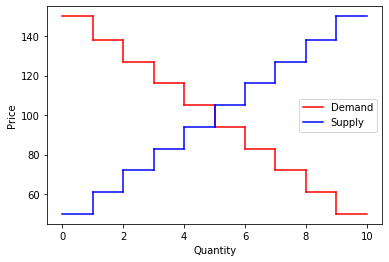

In [6]:
sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

You should now see demand and supply that you have configured for the market plotted above.

### Order Schedule 

The last thing we need to define is the order schedule. The order schedule, defines how orders to traders are replenished. This is the same idea as getting a new envelop in the live experiment we had in class. In BSE this can either happen simultaneously, where all traders are given new orders at the same time - exactly like we did in class, or continually where different traders are given new order at different times.

The order schedule is a dictionary containing 4 key-value pairs. The corresponding keys are **"sup", "dem", "interval"** and **"timemode"**.

- Sup and dem, should match the supply and demand schedules we want to use in our experiment (defined above);
- Interval is a number, that defines the number of seconds that the order schedule takes to cycle through all the traders and supply them with new orders;
- Timemode is a string that defines the method in which traders are re-supplied with orders and can be one of the following:
    - "periodic": where all the traders are given new orders periodically at the same time (at the beginning of every interval)
    - "drip-fixed": where orders are given to traders one at a time at fixed intervals 
    - "drip-jitter": similar to the previous but the intervals are not fixed, thus this can be thought of as having a drip-fixed timemode with some added random noise
    - "drip-poisson": where new orders arrive at intervals modeled with a poisson distribution
    
BSE makes sure that all traders are supplied with a new order once in the specified interval even if continues ("drip") timemodes are used. This can however be relaxed.

Let's define our own order schedule, using a 60 second interval and a periodic order replenishment:

In [7]:
# Solution:
order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

### Market Session

We now have defined all the things we need to run a market session!

To do this, we need to call the **market_session** function. This function take in a lot of arguments:

- The Session ID which is a string used to identify the experiment we are going to run;
- The start time and end time which are numbers and represent the start and end times of our experiment;
- The trader specification we want for our experiment;
- The order schedule we want for our experiment;
- A file where BSE will write data regarding the market session, we will see what data are written later on in more detail;
- A boolean flag that tells BSE whether or not to produce detailed data files;
- Another boolean flag telling BSE whether or not to produce output on the terminal during the run of the session (can be useful for debugging)

The following should run one market session with the specified configuration we defined in the previous cells and save the results in a csv file called 'test_1_avg_balance.csv':

In [8]:
trial_id = 'test_1'
tdump = open('test_1_avg_balance.csv','w')
dump_all = False
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

Open the 'test_1_avg_balance.csv' file and look at the data inside. What do you think these represent?

Let's now run the same code with dump_all flag as True:

In [9]:
trial_id = 'test_1'
tdump = open('test_1_avg_balance2.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

If you take a look at your folder now, you will see that the market session produced 3 csv files.

Let's start with "test_1_avg_balance2.csv", this is similar to "test_1_avg_balance.csv" but there are a lot more lines in it.

Each line in both files, starts with the session id, and the time (in seconds, relative to the experiment) at which the data is written to the file. 

**Question**: Given this, how are the 2 files different?

###### Solution:

    When dump_all is set to false, we only write to the file only once at the end. 
    In the case where it set to true, we write to the file every time a trade occurred (we will look at the code in more detail later).


The following two columns are the best bid and best offer (or 'None' if they're undefined) currently in the LOB.

Following are 4 columns for each trader type in the system (i.e. if there's only one trader type, there will be 4 columns, if there are 2 then 8 and so on and so forth). The 4 columns in order are the trader type, the total profit for the traders of this type, the number of traders of this type, and finally the average profit per trader of this type.

Additionally, when the dump_all flag is set, BSE produces 2 additional csv files. 

One (test_1_transactions.csv in this case) includes all the trades that took place writing each on a single line with the second column being the time the trade took place and the second the price of the trade. This is basically the tape of the exchange.

The other (test_1_blotters.csv in this case) saves the blotter of each trader (the blotter stores the details regarding the trades the trader was involved in). For each trader (both buyers and sellers) there is one line with the trader's id and the amount of items in it's blotter. Then for every item in it's blotter, a line is printed with the trader's id and the blotter item. Each blotter item contains the time the trade took place, the price, the id of the buyer, the id of the seller, and the quantity (which is always 1 in this version of BSE).

We can use the transactions csv file to plot a graph of the trades that took place using the first provided "plot_trades" function:

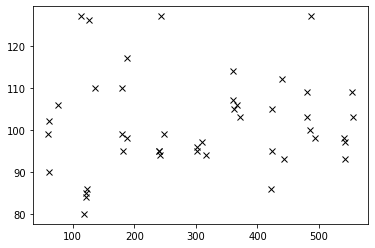

In [10]:
plot_trades('test_1')

### Static Market Sessions

Now let's try to put everything together. Let's try to configure the following markets:

1) A market that runs for 3 minutes and is populated with 10 ZIP buyers and 10 ZIP sellers. The supply and demand curves should have steps with regular intervals, minimum value at 100, and maximum value at 200. All traders should be resupplied with a new order at the same time every 10 seconds. Plot the supply and demand curves along with your results.

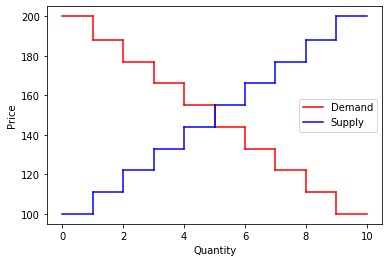

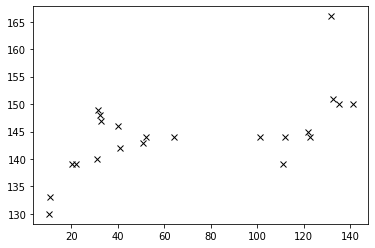

In [11]:
# Solution
sellers_spec = [('ZIP', 10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

sup_range = (100, 200)
dem_range = sup_range

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

start_time = 0
end_time = 60 * 3
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_2'
tdump = open('test_2_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_2')

You can also use the provided "n_runs_plot" function that we defined earlier (at the top of this worksheet) to run the same experiment multiple times and plot its graph. Plot the graph of 10 runs of the previous experiment:

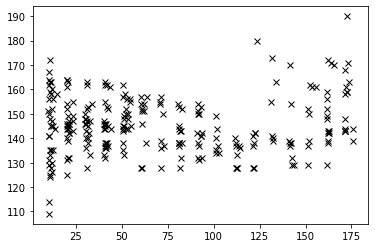

In [12]:
n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

2) A market that runs for 5 minutes and is populated with 3 buyers of every type except ZIC and 3 sellers of every type except SNPR. The supply curve should have a minimum value at 100 and a maximum value at 200 and demand curve should have a minimum value at 50, maximum value at 150. There shouldn't be any pattern in the step size. Traders should be resupplied with new orders continuously at fixed intervals with some noise and a re-supply cycle of 30 seconds. Plot the supply and demand curves along with your results.

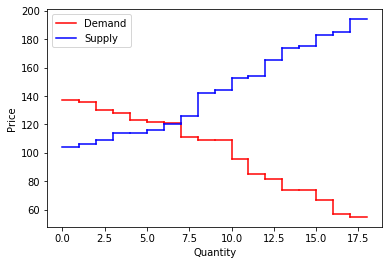

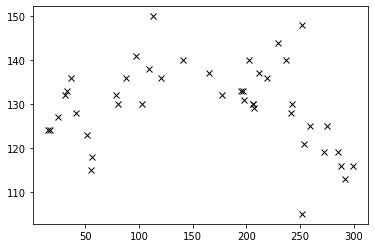

In [13]:
# Solution
sellers_spec = [('ZIP', 3), ('SHVR', 3), ('GVWY', 3), ('SNPR', 3), ('PRZI', 3), ('PRSH', 3)]
buyers_spec = [('ZIP', 3), ('ZIC', 3), ('SHVR', 3), ('GVWY', 3), ('PRZI', 3), ('PRSH', 3)]
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

sup_range = (100, 200)
dem_range = (50, 150)

sup_dem(18, [sup_range], 18, [dem_range], 'random')

start_time = 0
end_time = 60 * 5
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'random'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'random'}]

order_interval = 30
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-jitter'}

trial_id = 'test_3'
tdump = open('test_3_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_3')

### Advanced Static Markets 

The previous section cover everything you need to set up most static markets. In this section, we will see a method that creates a static market that is a little more complex. 

If you remember when we defined [supply and demand schedules](#Supply-and-Demand-Schedules), we said that the schedule dictionary has key "ranges" which is a list of tuples but we only looked at the case where we provided only one range tuple.

If the stepmode is set to random, we can actually provide multiple ranges (in all other stepmodes, BSE will ignore all ranges except from the first). What this does, is that instead of having just one supply or demand range, we have multiple and one is chosen at random every time an order is issued to a trader.

Try this feature out by using the previous market configuration but with supply and demand ranges 1-50, 100-200 and 300-350. Plot the supply and demand curves along with your results:

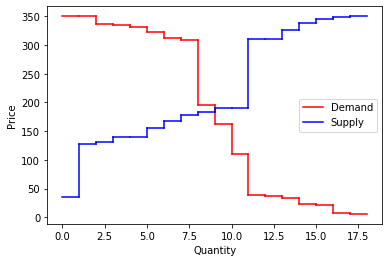

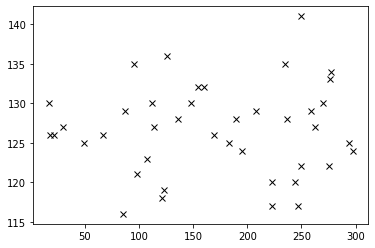

In [14]:
# Solution
sup_ranges = [(1, 50), (100,200), (300,350)]
dem_ranges = sup_ranges

sup_dem(18, sup_ranges, 18, dem_ranges, 'random')

supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': sup_ranges, 'stepmode': 'random'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': dem_ranges, 'stepmode': 'random'}]

trial_id = 'test_4'
tdump = open('test_4_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_4')

## Dynamic Markets

So far, we've looked at experiments that use the same supply and demand curves for the entire duration of the experiment (what we called static markets). In this section, we will see markets with variable supply and demand curves. BSE gives us 2 ways to dynamically change the supply and demand curves during an experiment.

### Market "Shocks"

The first way we will look at is something called a market "shock". What this means is that at specified points in the experiment we suddenly switch to different supply and/or demand schedules.

As we saw when we defined [supply and demand schedules](#Supply-and-Demand-Schedules), each schedule is a list of dictionaries. In static markets, we used one dictionary to define a schedule for the entire duration of the market session. In order to introduce one "shock" to the market, we provide two dictionaries with different configurations. Care must be taken to make sure that the combination of the intervals of the two (or more) schedules covers the entire duration of the market session. For example if we have a market that runs for 100 seconds, we could have the first schedule start at 0 ('from' = 0) and finish at 70 seconds ('to' = 70) and then have the second schedule start at 70 ('from' = 70) and finish at 100 ('to' = 100).

Let's try this using a market that runs for 10 minutes and is populated with 10 ZIP buyers and 10 ZIP sellers. The supply and demand curves should have steps with regular intervals, and initially minimum value at 50, and maximum value at 100. Then in the middle of the experiment, we introduce a "shock" where the minimum value of the supply and demand curves changes to 150 and maximum to 200. All traders should be resupplied with a new order at the same time every 15 seconds. Plotting the results should make the "shock" obvious.

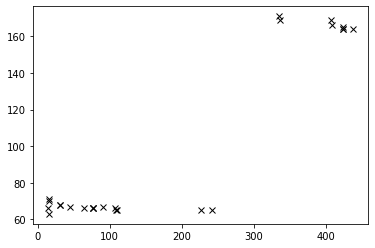

In [15]:
# Solution
sellers_spec = [('ZIP', 10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

range1 = (50, 100)
range2 = (150, 200)

start_time = 0
mid_time = 60 * 5
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': mid_time, 'ranges': [range1], 'stepmode': 'fixed'},
                   {'from': mid_time, 'to': end_time, 'ranges': [range2], 'stepmode': 'fixed'}]
demand_schedule = supply_schedule

order_interval = 15
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_5'
tdump = open('test_5_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_5')

Of course, we are not confined to having just one "shock" in the market. BSE allows us to have as many as we want. Let's try this by having the same experiment as before but this time the supply and demand curves move from (50, 100) to (150, 200) at 3 minutes and then back to (50, 100) at 7 minutes. Again plot all trades to see the effect of the 2 shocks. 

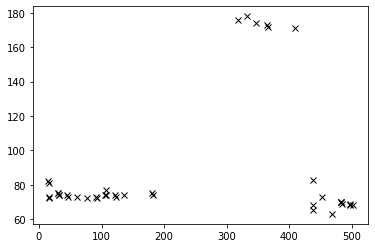

In [16]:
# Solution
sellers_spec = [('ZIP', 10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

range1 = (50, 100)
range2 = (150, 200)

start_time = 0
change1_time = 60 * 3
change2_time = 60 * 7
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': change1_time, 'ranges': [range1], 'stepmode': 'fixed'},
                   {'from': change1_time, 'to': change2_time, 'ranges': [range2], 'stepmode': 'fixed'},
                   {'from': change2_time, 'to': end_time, 'ranges': [range1], 'stepmode': 'fixed'}]
demand_schedule = supply_schedule

order_interval = 15
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_6'
tdump = open('test_6_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_6')

### Offset Function

The second way we can dynamically alter markets in BSE is by using offset functions. An offset function, is a function that can continuously alter the minimum and maximum values of the supply and demand curves while the experiment is running. How this works, it that the offset function is a function of time that returns a number that is added to the minimum and maximum values defined in the supply and/or demand ranges. With the current version of BSE you can find one offset function already build-in (function "schedule_offsetfn" shown below - a sine wave that grows in amplitude, and reduces its wavelength, as time progresses).

In [17]:
# schedule_offsetfn returns time-dependent offset, to be added to schedule prices
def schedule_offsetfn(t):
    pi2 = math.pi * 2
    c = math.pi * 3000
    wavelength = t / c
    gradient = 100 * t / (c / pi2)
    amplitude = 100 * t / (c / pi2)
    offset = gradient + amplitude * math.sin(wavelength * t)
    return int(round(offset, 0))

We can also create our own offset function in a similar way by creating a new function that takes as input time and returns a number. For example, "offset_1" and "offset_2" are two silly non-dynamic offset functions that always return constant offset of 1 or 2:

In [18]:
def offset_1(t):
    return 1

def offset_2(t):
    return 2

Define your own offset function that returns an offset that is initially equal to zero and increases by 1 every second:

In [19]:
# Solution:
def offset_t(t):
    return int(round(t,0))

To apply an offset function, we need to alter the supply and/or demand ranges. In section [supply and demand ranges](#Supply-and-Demand-Ranges) we saw how to create supply and demand ranges but we only use tuples with two numbers - the minimum and the maximum. Along with the two numbers we can provide a third item in the tuple, an offset function which will be used on both the minimum and maximum values in the range. If we want to use a different offset function for the minimum and a different one for the maximum value in a range we can also do that by providing a tuple with four items in it, the minimum value, the maximum value, the offset function that will be applied to the minimum value and the offset function to be applied to the maximum value.

For example, the following creates two ranges each with a different offset applied to both the minimum and maximum value: 

In [20]:
range_offset1 = (50, 100, schedule_offsetfn)
range_offset2 = (150, 200, offset_t)

Similarly, the following creates a range with two offset functions the first one applied to the minimum and the second one to the maximum:

In [21]:
range_offset_both = (50, 100, offset_1, offset_2)

Run a market session using the previous market configuration but this time replace range1 with range_offset1 and range2 with range_offset2. Plot the results:

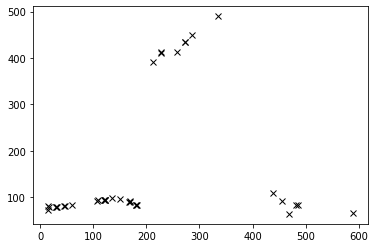

In [22]:
# Solution
sellers_spec = [('ZIP', 10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

range1 = (50, 100, schedule_offsetfn)
range2 = (150, 200, offset_t)

start_time = 0
change1_time = 60 * 3
change2_time = 60 * 7
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': change1_time, 'ranges': [range1], 'stepmode': 'fixed'},
                   {'from': change1_time, 'to': change2_time, 'ranges': [range2], 'stepmode': 'fixed'},
                   {'from': change2_time, 'to': end_time, 'ranges': [range1], 'stepmode': 'fixed'}]
demand_schedule = supply_schedule

order_interval = 15
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_6'
tdump = open('test_6_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_6')

## Market Configuration Summary

In the previous sections, we explored all experiment configuration options available in BSE. We first saw static markets and then dynamic. For more information check the __[BSE wiki](https://github.com/davecliff/BristolStockExchange/wiki/4.-Altering-the-market-supply-and-demand)__.  

# Code Exploration

The current version of BSE has more than 2000 lines of code so it is easy to get lost, so in this section we will see how the most important parts of BSE work.

Starting with the Exchange class this is the backbone of BSE. It inherits from the Orderbook class (which itself inherits from the Orderbook_half class). We won't go into too much detail on how the exchange works as traders don't actually interact with it directly. The important thing to understand is that the exchange maintains a LOB, is able to process orders, and it keeps a list of transactions (the tape). You don't need to understand much more to work with BSE, but if you want to learn more, the most important method is "process_order2" and I suggest that you start from there.

When we want to run an experiment with BSE, we configure the experiment (as we saw in detail in the previous sections) and then call the "market_session" function. This function is responsible for all the functionality of BSE. How it roughly works, is: 

- It first populates the market with traders (using the "populate_market" function) by instantiating them from their respective classes and gives each a unique id.
- Then loops around until the end of the experiment. The time of the market is increased by a timestep on every iteration. One timestep is not one (market) second but is equal to a fraction of a second. The exact fraction is determined by the number of traders (e.g. for a market with 5 sellers and 5 buyers, the timestep is 1/10 of a second).
- On every iteration:
    - A call to the "customer_orders" is made. This function does one of two things. It initially creates limit orders for all traders that will be given to them in the future (remember traders are resupplied with orders based on a schedule with an interval). If it already created the orders, on future calls it checks which of those orders should be issued (based on the current time) to the traders and sends them by calling the "add_order" method of that trader.
    - A trader is selected at random and the trader's "getorder" method is called thus allowing that trader to trade. What this means, is that the selected trader can issue a new order (which adjusts its current order if the trade has one) or can do nothing if the trader is happy with its current order (or lack of order). (Note: This trader order is different from the one given to the trader by "customer_orders". This one is the order the trader issues to the market while the other is the trader's private value) 
    - If the selected trader issued a new order:
        - That order is processed by the exchange using the "process_order2" method. This method either returns a "transaction_record" indicating that the order was executed and resulted in a trade or None indicating that the order was not executed (i.e. just added to the LOB). The transaction record contains all information of a trade (time, price, involved parties etc). If the order resulted to a trade, the two traders involved are also notified using their "bookkeep" methods.
        - After the order is processed, all traders are notified with the new state of the LOB (and the trade if it happened). This allows traders to adjust their strategy given the new state of the LOB.
- Finally at the end of the session the function produces the appropriate output files.